# 🐁 Mouse Tracking Video Renderer 🐁

While looking at the articles about the Social Action Recognition in Mice, I noticed something: the regions of the mice are marked from a bird's eye view, and unfortunately, in our datasets, they are found as parquets.

* CalMS21 at NeurIPS (https://arxiv.org/pdf/2104.02710.pdf), You can see the green and blue dotted lines in the picture below.
  
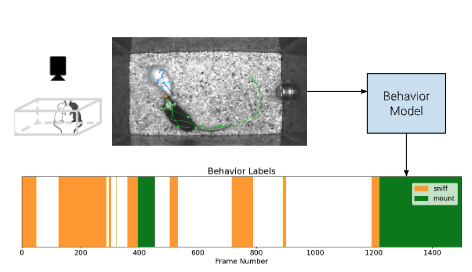

I decided to convert the Parquet dataset into video and wanted to share the implementation with you. I've set it up for a single instance, but you can adapt it to process all of them with a small adjustment in the code. Be aware that this might require a significant amount of memory.
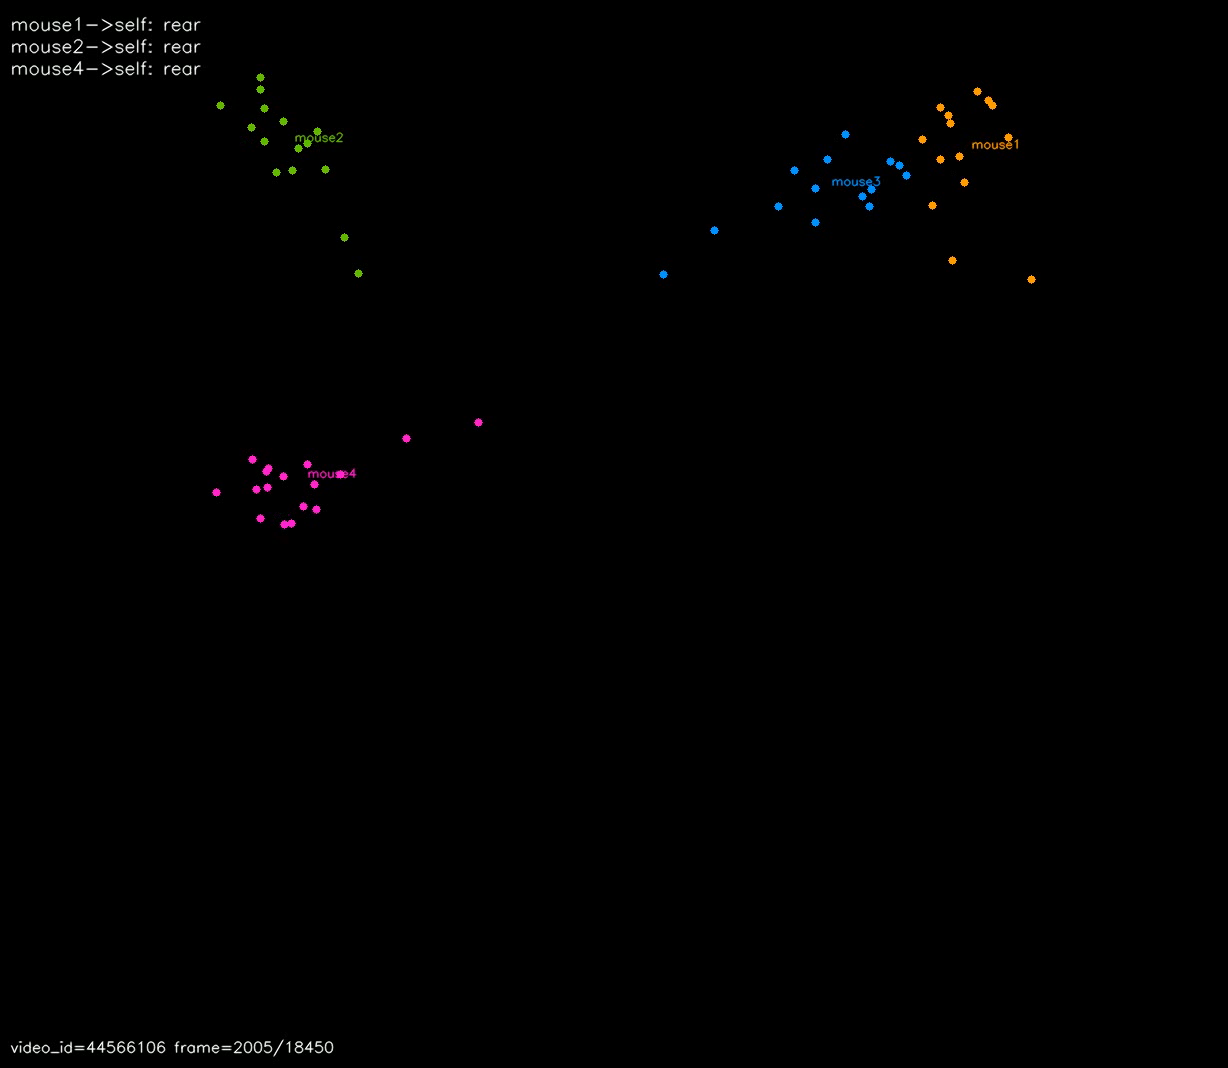

### Contents
1. Loading required libraries
2. Defining video creation functions
3. Rendering the video
4. Playing the video inside the Kaggle notebook (If it's over 100 MB, it may be struggle to open it in Kaggle Notebook. Please pay attention to the codes in the cells, I've explained them as clearly as possible.)

### Contact 

I'm always open to discussing new projects, collaboration opportunities, or interesting ideas. Let's connect!

<div style="text-align: left;">
  <a href="https://www.linkedin.com/in/osman-bayram-785931250/" target="_blank">
    <img src="https://custom-icon-badges.demolab.com/badge/LinkedIn-0A66C2?logo=linkedin-white&logoColor=fff" alt="LinkedIn">
  </a>
  <br> <a href="https://github.com/OsmanByrm" target="_blank">
    <img src="https://img.shields.io/badge/GitHub-%23121011.svg?logo=github&logoColor=white" alt="GitHub">
  </a>
</div>

## 1. Loading Required Libraries

First we load the libraries needed to create and display the video.

In [ ]:
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Iterable

import cv2
import numpy as np
import pandas as pd
from IPython.display import Video, display

print("Libraries loaded successfully!")

## 2. Data Structures and Helper Functions

We define a dataclass to hold video metadata and the helper functions needed.

In [ ]:
@dataclass
class Metadata:
    """Holds video metadata information"""
    lab_id: str
    video_id: str
    fps: float
    width: int
    height: int

In [ ]:
def load_metadata(metadata_csv: Path, video_id: str, lab_id_hint: Optional[str] = None) -> Metadata:
    """
    Load metadata information for the specified video_id from a CSV file.
    
    Args:
        metadata_csv: Path to the train.csv or test.csv file
        video_id: ID of the video to render
        lab_id_hint: Optional lab_id to disambiguate when multiple matches exist
    
    Returns:
        Metadata: Video metadata information
    """
    df = pd.read_csv(metadata_csv)
    df["video_id"] = df["video_id"].astype(str)

    query = df[df["video_id"] == str(video_id)]
    if lab_id_hint:
        query = query[query["lab_id"] == lab_id_hint]

    if query.empty:
        raise ValueError(f"Video {video_id} not found: {metadata_csv}")
    if len(query) > 1 and not lab_id_hint:
        options = ", ".join(sorted(query["lab_id"].unique()))
        raise ValueError(
            f"Multiple lab_id found for video {video_id}. Please specify lab_id. Options: {options}"
        )

    row = query.iloc[0]
    return Metadata(
        lab_id=str(row["lab_id"]),
        video_id=str(row["video_id"]),
        fps=float(row["frames_per_second"]),
        width=int(row["video_width_pix"]),
        height=int(row["video_height_pix"]),
    )

print("load_metadata function defined")

In [ ]:
def build_color_map(num_entries: int) -> Dict[int, Tuple[int, int, int]]:
    """
    Creates a different color palette for each mouse.
    
    Args:
        num_entries: Number of colors
    
    Returns:
        Dict: Mapping from Mouse ID to (B, G, R) color tuple
    """
    palette: List[Tuple[int, int, int]] = [
        (0, 153, 255),    # Orange
        (0, 204, 102),    # Green
        (255, 153, 0),    # Blue
        (204, 0, 255),    # Pink
        (255, 51, 51),    # Red
        (102, 255, 204),  # Light green
        (255, 102, 178),  # Light pink
        (153, 255, 51),   # Lime green
    ]
    return {idx + 1: palette[idx % len(palette)] for idx in range(num_entries)}

print("build_color_map function defined")

In [ ]:
def compute_centroids(frame_df: pd.DataFrame) -> Dict[int, Tuple[int, int]]:
    """
    Calculates the centroid by taking the average of body part coordinates for each mouse.
    
    Args:
        frame_df: Tracking data for a single frame
    
    Returns:
        Dict: Mapping from Mouse ID to (x, y) centroid coordinates
    """
    centroids: Dict[int, Tuple[int, int]] = {}
    for mouse_id, group in frame_df.groupby("mouse_id"):
        coords = group[["x", "y"]].to_numpy(dtype=np.float32)
        if np.isnan(coords).all():
            continue
        mean_x = float(np.nanmean(coords[:, 0]))
        mean_y = float(np.nanmean(coords[:, 1]))
        centroids[int(mouse_id)] = (int(round(mean_x)), int(round(mean_y)))
    return centroids

print("compute_centroids function defined")

In [ ]:
def gather_active_annotations(
    annotation_df: pd.DataFrame,
    frame_number: int,
) -> List[Tuple[int, int, str]]:
    """
    Finds active behaviors in a specific frame.
    
    Args:
        annotation_df: Annotation data
        frame_number: Frame number
    
    Returns:
        List: (agent_id, target_id, action) tuples
    """
    if annotation_df is None or annotation_df.empty:
        return []

    active = annotation_df[
        (annotation_df["start_frame"] <= frame_number)
        & (annotation_df["stop_frame"] >= frame_number)
    ]
    return list(
        active[["agent_id", "target_id", "action"]].itertuples(index=False, name=None)
    )

def format_actions(actions: Iterable[Tuple[int, int, str]]) -> List[str]:
    """
    Converts annotation information to readable text format.
    """
    lines: List[str] = []
    for agent_id, target_id, action in actions:
        agent = f"mouse{agent_id}"
        target = f"mouse{target_id}" if agent_id != target_id else "self"
        lines.append(f"{agent}->{target}: {action}")
    return lines

def draw_annotation_overlay(
    canvas: np.ndarray,
    lines: List[str],
    origin: Tuple[int, int] = (10, 30),
) -> None:
    """
    Writes annotation information on top of the video.
    """
    if not lines:
        return

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.6
    line_height = 22
    for idx, text in enumerate(lines[:8]):
        position = (origin[0], origin[1] + idx * line_height)
        cv2.putText(canvas, text, position, font, font_scale, (255, 255, 255), 1, cv2.LINE_AA)

print("Annotation helper functions defined")

## 3. Main Video Rendering Function

Main function that reads tracking data from parquet files and converts it to MP4 video.

In [ ]:
def render_video(
    metadata: Metadata,
    tracking_path: Path,
    annotation_path: Optional[Path],
    output_path: Path,
    frame_skip: int = 1,
    radius: int = 4,
    thickness: int = -1,
    draw_annotations: bool = False,
    output_width: int = 1228,  # Output video width, you can also change (piksel)
    output_height: int = 1068,  # Output video hight, you can also change (piksel) originial size 1228x1068
) -> None:
    """
    Creates an MP4 video from a tracking parquet file.
    
    Args:
        metadata: Video metadata information
        tracking_path: Path to the tracking parquet file
        annotation_path: Path to the annotation parquet file (optional)
        output_path: Path to the output video file
        frame_skip: Render every N frames (for speedup)
        radius: Diameter of body part points (pixels)
        thickness: Circle thickness (negative value creates filled circle)
        draw_annotations: Add behavior information on top of video
        output_width: Output video width in pixels (default: like 480)
        output_height: Output video height in pixels (default: like 480)
    """
    if not tracking_path.exists():
        raise FileNotFoundError(f"Tracking parquet not found: {tracking_path}")

    print(f"Reading tracking data: {tracking_path}")
    tracking_df = pd.read_parquet(tracking_path)
    
    # Validate that this is a tracking file with required columns
    required_columns = ["video_frame", "mouse_id", "x", "y"]
    missing_columns = [col for col in required_columns if col not in tracking_df.columns]
    if missing_columns:
        available_columns = list(tracking_df.columns)
        raise ValueError(
            f"Invalid tracking file. Missing required columns: {missing_columns}\n"
            f"Available columns: {available_columns}\n"
            f"Make sure you're using a tracking file (from train_tracking/ or test_tracking/), "
            f"not an annotation file (from train_annotation/)."
        )
    
    tracking_df = tracking_df.sort_values("video_frame")

    annotation_df: Optional[pd.DataFrame] = None
    if annotation_path and annotation_path.exists():
        print(f"Reading annotation data: {annotation_path}")
        annotation_df = pd.read_parquet(annotation_path)

    frames = np.sort(tracking_df["video_frame"].unique())
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    
    # Ölçekleme faktörlerini hesapla
    scale_x = output_width / metadata.width
    scale_y = output_height / metadata.height
    
    print(f"Original video size: {metadata.width}x{metadata.height}")
    print(f"Output video size: {output_width}x{output_height}")
    print(f"Scale factors: X={scale_x:.3f}, Y={scale_y:.3f}")
    
    writer = cv2.VideoWriter(
        str(output_path), 
        fourcc, 
        metadata.fps / frame_skip, 
        (output_width, output_height)
    )
    
    if not writer.isOpened():
        raise RuntimeError(f"VideoWriter could not be opened: {output_path}")

    color_map = build_color_map(int(tracking_df["mouse_id"].max()))
    total_frames = len(frames)
    
    print(f"Creating video: {total_frames} frames, rendering every {frame_skip} frames")

    try:
        for idx, frame_number in enumerate(frames[::frame_skip]):
            frame_df = tracking_df[tracking_df["video_frame"] == frame_number]
            canvas = np.zeros((output_height, output_width, 3), dtype=np.uint8)

            # Draw body part points (koordinatları ölçeklendir)
            for _, row in frame_df.iterrows():
                x_orig = row["x"]
                y_orig = row["y"]
                if np.isnan(x_orig) or np.isnan(y_orig):
                    continue
                
                # Koordinatları yeni boyuta ölçeklendir
                x = int(round(x_orig * scale_x))
                y = int(round(y_orig * scale_y))
                
                color = color_map.get(int(row["mouse_id"]), (255, 255, 255))
                cv2.circle(canvas, (x, y), radius, color, thickness)

            # Draw mouse labels (centroid'leri ölçeklendir)
            centroids = compute_centroids(frame_df)
            for mouse_id, (cx_orig, cy_orig) in centroids.items():
                # Centroid'leri ölçeklendir
                cx = int(round(cx_orig * scale_x))
                cy = int(round(cy_orig * scale_y))
                
                label = f"mouse{mouse_id}"
                cv2.putText(
                    canvas,
                    label,
                    (cx + 6, cy - 6),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.4,  # Font boyutunu biraz küçülttük
                    color_map.get(mouse_id, (200, 200, 200)),
                    1,
                    cv2.LINE_AA,
                )

            # Add annotation information
            if draw_annotations and annotation_df is not None:
                active_actions = gather_active_annotations(annotation_df, int(frame_number))
                overlay_lines = format_actions(active_actions)
                draw_annotation_overlay(canvas, overlay_lines)

            # Footer text
            footer_text = f"video_id={metadata.video_id} frame={frame_number}/{frames[-1]}"
            cv2.putText(
                canvas,
                footer_text,
                (10, output_height - 16),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,  # Font boyutunu biraz küçülttük
                (255, 255, 255),
                1,
                cv2.LINE_AA,
            )
            writer.write(canvas)

            if (idx + 1) % 500 == 0:
                print(f"[{idx + 1}/{total_frames // frame_skip}] frame {frame_number} rendered")
    finally:
        writer.release()

    print(f"Video successfully saved: {output_path}")
    print(f"Final video size: {output_width}x{output_height}")

print("render_video function defined")

## 4. Video Creation and Display

Now we will create a video and play it inside the Kaggle notebook.

### Set Parameters

Edit the following parameters according to your data:

In [ ]:
# Video parameters - Change these according to your data
VIDEO_ID = "44566106"  # Video ID you want to render
LAB_ID = None  # If there are multiple labs, write lab_id here, otherwise leave None

# File paths 
METADATA_CSV = Path("/kaggle/input/MABe-mouse-behavior-detection/train.csv")
TRACKING_ROOT = Path("/kaggle/input/MABe-mouse-behavior-detection/train_tracking")
ANNOTATION_ROOT = Path("/kaggle/input/MABe-mouse-behavior-detection/train_annotation")

# Output file
OUTPUT_VIDEO = Path(f"video_{VIDEO_ID}.mp4")

# Rendering settings
FRAME_SKIP = 1  # Render every N frames (1 = every frame)
RADIUS = 4  # Diameter of body part points
THICKNESS = -1  # Circle thickness (-1 = filled)
DRAW_ANNOTATIONS = True  # Show behavior information

print("Parameters set")
print(f"Video ID: {VIDEO_ID}")
print(f"Output file: {OUTPUT_VIDEO}")

### Load Metadata

We read video information from the CSV file.

In [ ]:
metadata = load_metadata(METADATA_CSV, VIDEO_ID, LAB_ID)

print(f"Metadata loaded successfully:")
print(f"  Lab ID: {metadata.lab_id}")
print(f"  Video ID: {metadata.video_id}")
print(f"  FPS: {metadata.fps}")
print(f"  Dimensions: {metadata.width}x{metadata.height} pixels")

### Determine File Paths

We create paths for tracking and annotation parquet files.

In [ ]:
tracking_path = TRACKING_ROOT / metadata.lab_id / f"{metadata.video_id}.parquet"
annotation_path = ANNOTATION_ROOT / metadata.lab_id / f"{metadata.video_id}.parquet"

print(f"Tracking file: {tracking_path}")
print(f"Tracking file exists: {tracking_path.exists()}")
if tracking_path.exists():
    print(f"  Full path: {tracking_path.absolute()}")
else:
    print(f"  WARNING: Tracking file not found! Check if path is correct.")
    print(f"  TRACKING_ROOT: {TRACKING_ROOT}")
    print(f"  lab_id: {metadata.lab_id}")
    print(f"  video_id: {metadata.video_id}")

print(f"\nAnnotation file: {annotation_path}")
print(f"Annotation file exists: {annotation_path.exists()}")
if annotation_path.exists():
    print(f"  Full path: {annotation_path.absolute()}")

### Create the Video

This cell creates the video. It may take some time for large videos.

In [ ]:
render_video(
    metadata=metadata,
    tracking_path=tracking_path,
    annotation_path=annotation_path if annotation_path.exists() else None,
    output_path=OUTPUT_VIDEO,
    frame_skip=FRAME_SKIP,
    radius=RADIUS,
    thickness=THICKNESS,
    draw_annotations=DRAW_ANNOTATIONS,
)

### Playing the Video in Kaggle Notebook

We play the created video directly inside the notebook.

In [ ]:
"""
-> Issue: If the video is over 100 MB than Kaggle Notebook, it can't be opened.
We can open it by reducing the video size. **ATTENTION: SOME VIDEOS MAY NOT OPEN !**

"""

import os
from IPython.display import Video, display

# Path of Video 
video_path = "/kaggle/working/video_44566106.mp4" # !! ATTENTION !!
preview_path = "/kaggle/working/video_preview.mp4"

os.system(f'ffmpeg -i "{video_path}" -vf scale=320:-1 -b:v 1M -an -y "{preview_path}"')


In [ ]:
# Now we can safely open the small preview file in the cell
## If you want to open video in cell pls remove comment 
# display(Video(preview_path, embed=True, width=320))

## 5. Additional Information

### Video Properties

Let's check the properties of the created video.

In [ ]:
import os

if OUTPUT_VIDEO.exists():
    file_size_mb = os.path.getsize(OUTPUT_VIDEO) / (1024 * 1024)
    print(f"Video file size: {file_size_mb:.2f} MB")
    print(f"Video file path: {OUTPUT_VIDEO.absolute()}")
    
    # Check video information with OpenCV
    cap = cv2.VideoCapture(str(OUTPUT_VIDEO))
    if cap.isOpened():
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        duration = frame_count / fps if fps > 0 else 0
        
        print(f"Total frame count: {frame_count}")
        print(f"FPS: {fps:.2f}")
        print(f"Video duration: {duration:.2f} seconds")
        cap.release()
else:
    print("Video file not found!")

## Notes

- Video creation process may take a long time depending on the number of frames
- You can create faster (but less smooth) videos by increasing the FRAME_SKIP parameter
- You can show or hide behavior information on the video with the DRAW_ANNOTATIONS parameter
- You can change the appearance of body part points with the RADIUS and THICKNESS parameters
- The created video file is saved in the directory where the notebook is running
- To download the video in the Kaggle environment, you can download it from the output files section on the right